# M3 – Week 2
### Bag of Visual Words for Image Classification

#### Team 6
- Alex Carrillo Alza
- Eduard Hogea
- Guillem Martinez Sanchez


### **Table of Contents**

*   [1. Dataset](#dataset)
*   [2. Dense SIFT](#dense-sift)
*   [Normalization](#normalization)
*   [Spatial Pyramids](#pyramids)
*   [3. SVM Classifier](#svm)

In [1]:
!pip install optuna
!pip install ipywidgets

In [2]:
!pip install itables

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm.notebook import tqdm
from typing import Tuple
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
import optuna
import cv2
from typing import List, Tuple, Dict
from joblib import Parallel, delayed, cpu_count
from typing import List, Dict, Tuple, Any

In [4]:
#delete later
import os
import cv2
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
import pandas as pd
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from sklearn import svm
import seaborn as sns

<IPython.core.display.Javascript object>

In [5]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128, verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [6]:
def dimensionality_reduction(X_train: np.ndarray, Y_train: np.ndarray, X_validate: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies dimensionality reduction to the training and validation data.

    Args:
        trial (int): The trial number
        X_train (np.ndarray): The training data
        Y_train (np.ndarray): The training labels, needed for supervised dimensionality reduction
        X_validate (np.ndarray): The validation data
    """
    lda = LinearDiscriminantAnalysis(n_components=7) # 7 is the best parameter from last week, no need to do hyperparam search
    X_train_DR = lda.fit_transform(X_train, Y_train)
    X_validate_DR = lda.transform(X_validate)

    return X_train_DR, X_validate_DR

In [7]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    """
    This function prints and returns the predictions' accuracy
    """
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

In [8]:
def compute_image_descriptors(image: np.ndarray, detector_name: str, detector, step_size: int, kp_sizes: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    if detector_name == 'dense_sift':
        keypoints = create_dense_kp(gray.shape, step_div_size=step_size, kp_sizes = kp_sizes)
        _, descriptors = detector.compute(gray, keypoints)
    else:
        keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(
    images: List[np.ndarray],
    labels: Tuple,
    detector: str,
    n_features: int,
    desc: str,
    step_div_size: int = 10,
    n_process: int = cpu_count(),
    verbose: bool = False,
    testing: bool = False,
    kp_sizes: int = 1
    ):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector_name, detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector_name, detector, step_div_size, kp_sizes) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    if testing: 
        return descriptors, labels
    return filtered_descriptors, filtered_labels

In [9]:
def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return name, detector

In [10]:
def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images
def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)

In [11]:
def generate_codebook(descriptors: np.ndarray, codebook_size: int = 128) -> MiniBatchKMeans:
    """
    Generates a codebook from a given ndarray containing descriptors. Mainly, training descriptors
    """
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    return codebook

## 1. Dataset <a id="dataset"></a>

In [12]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat','rb'))
train_labels = pickle.load(open('../MIT_split/train_labels.dat','rb'))
test_labels = pickle.load(open('../MIT_split/test_labels.dat','rb'))
# Load images
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

Loading TRAIN images...: 100%|████████████| 1881/1881 [00:01<00:00, 1678.87it/s]


read: 1881 images


Loading TEST images...: 100%|█████████████| 1881/1881 [00:00<00:00, 1992.03it/s]

read: 1881 images


In [13]:
class Dataset():
    def __init__(self, images_filenames, labels):
        self.data = images_filenames
        self.labels = labels
    
    def visualize(self, samples_per_class=5):
        print(f'Total number of training samples: {len(self.data)}')
        # get unique classses
        classes = np.unique(np.array(self.labels))
        num_classes = len(classes)
        #set size for plot
        plt.figure(figsize=(15,8))

        for y, cls in enumerate(classes):
            _idxs = np.flatnonzero(np.array(self.labels) == cls)
            idxs = np.random.choice(_idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(Image.open(self.data[idx]))
                plt.axis('off')
                if i == 0:
                    plt.title(f'{cls} ({len(_idxs)})')
        plt.show()
        
    def show_sample(self, indx):
        return Image.open(self.data[indx])


train = Dataset(train_images_filenames, train_labels)
test = Dataset(test_images_filenames, test_labels)

Total number of training samples: 1881


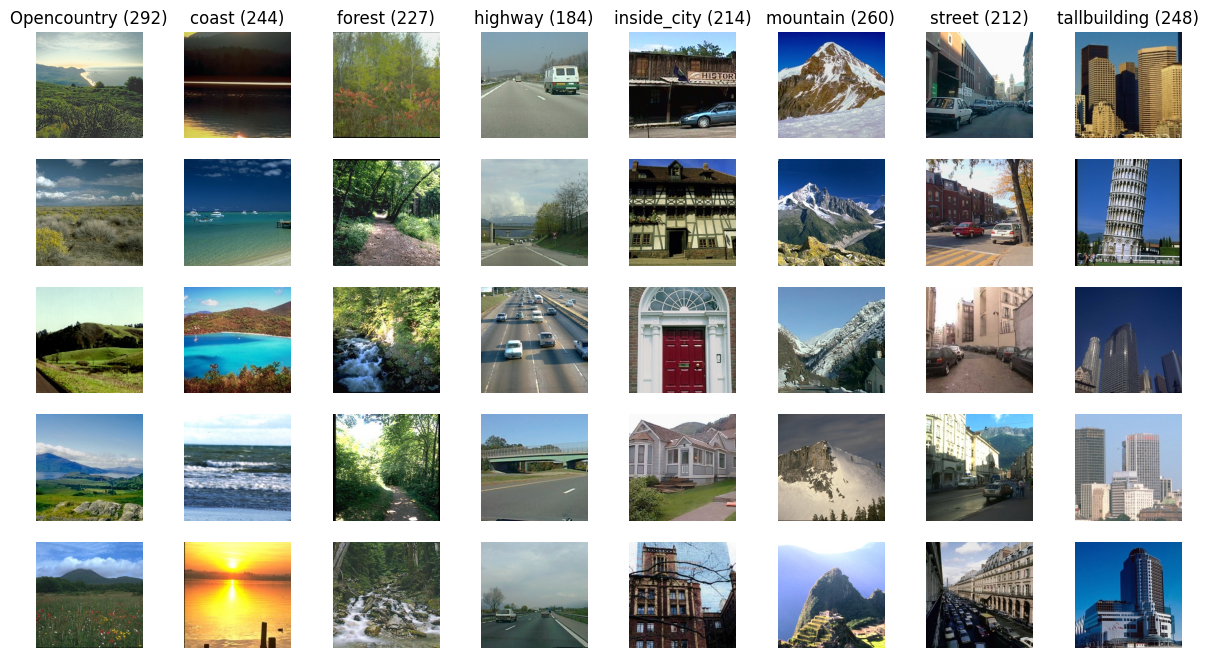

In [14]:
train.visualize()

## Dense SIFT <a id="dense-sift"></a>

In [15]:
# To create dense keypoints
def create_dense_kp(img_shape, step_div_size=50, kp_sizes=1):
    keypoints = []
    init_step_size_x = max(img_shape[1] // step_div_size, 8)
    init_step_size_y = max(img_shape[0] // step_div_size, 8)
    current_step_size_x = init_step_size_x
    current_step_size_y = init_step_size_y
    keypoints += [cv2.KeyPoint(x, y, kp_sizes) for y in range(0, img_shape[0], current_step_size_y) 
                                              for x in range(0, img_shape[1], current_step_size_x)]
    return keypoints

# let's sample an image
sample = train_images_filenames[76]
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# To compute dense SIFT
SIFTdetector = cv2.SIFT_create()
dense_kp = create_dense_kp(gray.shape, step_div_size=10, kp_sizes=1)                              
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)

In [16]:
def show_keypoints(img_path, descriptor=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kp = descriptor.detect(gray)
    else:
        kp = kps

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2, figsize=(8,4))
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

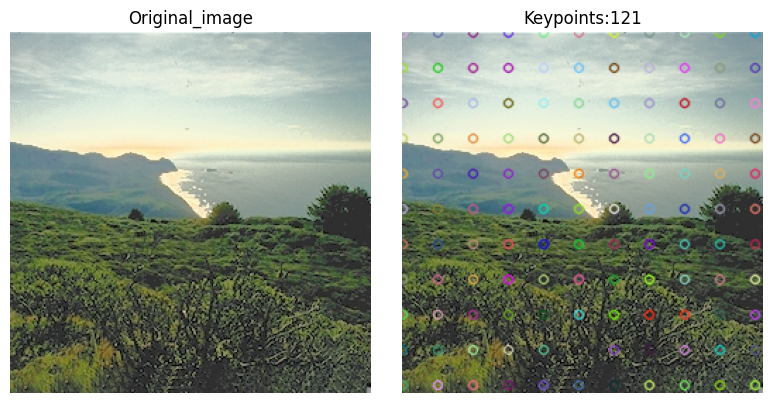

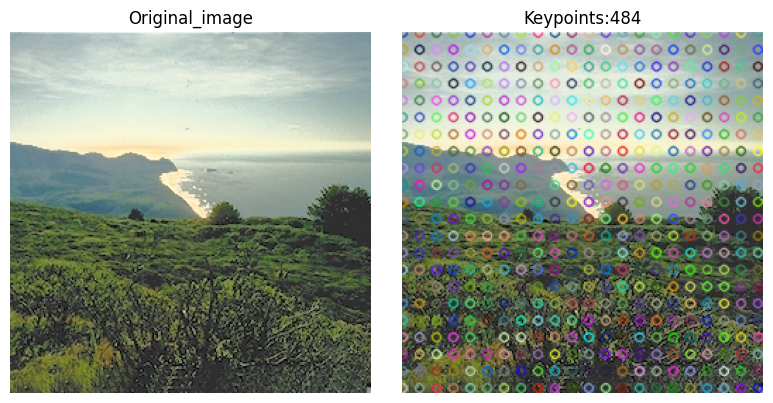

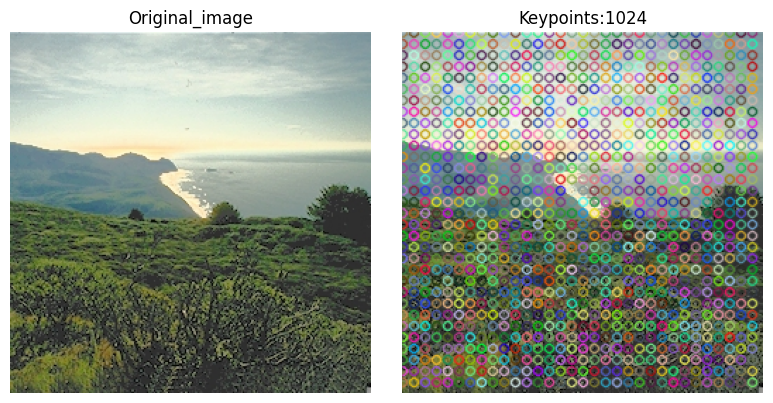

In [17]:
dense_kp = []
counter = 0
for steps in [10,20,50]:
    dense_kp.append(create_dense_kp(gray.shape, step_div_size=steps, kp_sizes=1))                              
    _,dense_sift_des = SIFTdetector.compute(gray, dense_kp[counter])
    counter+= 1
for kps in dense_kp:
    show_keypoints(sample, kps=kps)

### Testing the Dense Sift

In [18]:
params = {
    'detector': ['dense_sift'],
    'n_features': [2000],
    'codebook_size': [1024],
    'n_neighbors': [5, 9],
    'metric': ["manhattan"],
    'step_size': [10,20,40],
    'dr_methods': ["pca", "lda"],
    'kp_sizes': [10,20,40,100,200]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn_week2.csv'

results = []

for n_features in params['n_features']:
    for step_div_size in params['step_size']:
        for kp_sizes in params['kp_sizes']:

            train_descriptors, filtered_train_labels = compute_descriptors(
                images=train_images,
                labels=train_labels,
                detector='dense_sift',
                n_features=n_features,
                step_div_size = step_div_size,
                kp_sizes = kp_sizes,
                desc='Computing descriptors for TRAIN images...'
            )


            for codebook_size in params['codebook_size']:

                cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                train_visual_words = compute_visual_words(
                    descriptors=train_descriptors,
                    codebook=cbook,
                    codebook_size=codebook_size,
                    desc="Computing visual words vocabulary with TRAIN descriptors..."
                )
            clf = KNeighborsClassifier(n_jobs=-1)
            clf_grid = GridSearchCV(
                estimator=clf,
                param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                cv=8,
                scoring=evaluation_metrics,
                refit="accuracy",
                return_train_score=True)
            clf_grid.fit(train_visual_words, filtered_train_labels)

            idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

            # Params
            n_neighbors = clf_grid.best_params_['n_neighbors']
            distance = clf_grid.best_params_['metric']

            results_data = ['dense_sift', n_features, step_div_size, kp_sizes,codebook_size, n_neighbors, distance]

            # Scores
            for eval_metric in evaluation_metrics:
                train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                results_data.extend([train_score, val_score, std_train_score, std_val_score])

            results.append(results_data)
            print(f"Appended GridSearchCV results for {'dense_sift'} with {n_features} features, {step_div_size} step size, {kp_sizes} kp scale and {codebook_size} codebook size.")

columns = ['detector', 'n_features','step_size', 'kp_sizes', 'codebook_size', 'n_neighbors', 'distance'] \


for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

Appended GridSearchCV results for dense_sift with 2000 features, 10 step size, 10 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 10 step size, 20 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 10 step size, 40 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 10 step size, 100 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 10 step size, 200 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 20 step size, 10 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 20 step size, 20 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 20 step size, 40 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 20 step size, 100 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 20 step size, 200 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 40 step size, 10 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 40 step size, 20 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 40 step size, 40 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 40 step size, 100 kp scale and 1024 codebook size.


Appended GridSearchCV results for dense_sift with 2000 features, 40 step size, 200 kp scale and 1024 codebook size.


In [19]:
df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

Saved results to results/hyper_params_knn_week2.csv


In [20]:
df_copy = df.copy()
df_copy = df_copy.sort_values("val_accuracy", ascending=False)
df_copy = df_copy.drop_duplicates(subset=["detector"], keep="first")
#df_copy.drop(columns=df.columns[0], axis=1, inplace=True)
df_copy = df_copy.drop(df_copy.iloc[:, 9:],axis = 1)
best_params = df_copy.values.tolist()

df_copy #best values found for dense sift with KNN

detector  n_features  step_size  kp_sizes  codebook_size  n_neighbors  \
10  dense_sift        2000         40        10           1024            9   

     distance  train_accuracy  val_accuracy  
10  manhattan        0.855852      0.799599

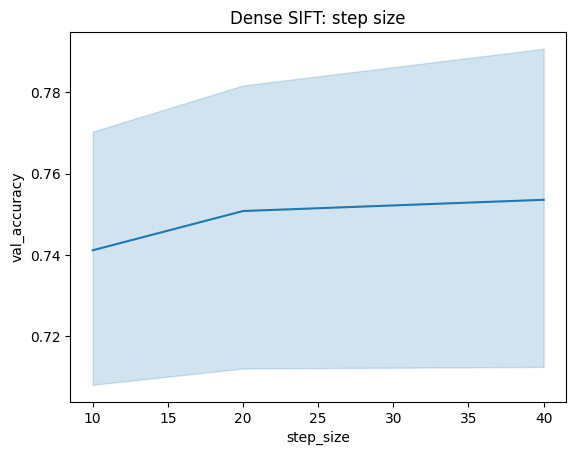

In [30]:
sns.lineplot(data = df, x = 'step_size', y = "val_accuracy")
plt.title("Dense SIFT: step size")
plt.show()

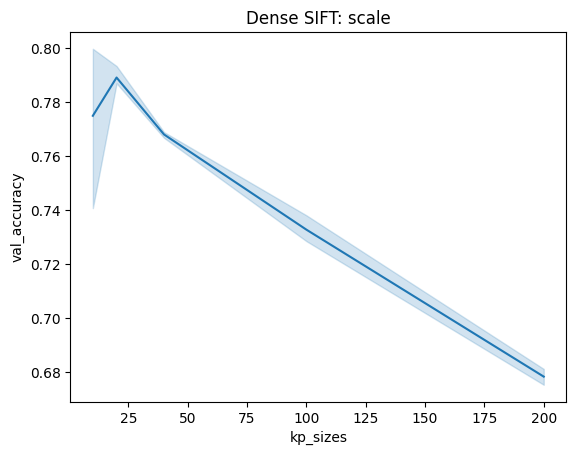

In [22]:
sns.lineplot(data = df, x = 'kp_sizes', y = "val_accuracy")
plt.title("Dense SIFT: scale")
plt.show()

## Normalization <a id="normalization"></a>


Normalization is the process of scaling individual samples to have unit norm, to have features in the same scale and improve model performance. We use it to normalize the histograms of visual words.

The normalized feature vector is 
$$
x_{\text {norm }} = \frac{x}{N}
$$
with

- **L1 norm** $\to$ components of the feature vector sum 1
$$
N = \|x\|_{1} = \sum_{i}|x_{i}|
$$

- **L2 norm (euclidean)** $\to$ modulus of the feature vector is 1
$$
N = \|x\|_{2} = \sqrt{\sum_{i}x_i^2}
$$

- **Max norm**
$$
N = \|x\|_{\infty} = \max |x_{i}|
$$

- **Standar Scaler** $\to$ remove the mean and scale to unit variance
$$
x_{\text {norm }}=\frac{x-\mu}{\sigma} ; \quad \mu: \text{mean}, \ \sigma: \text{std}
$$

In [23]:
def normalization(X: np.ndarray, norm='scaler'):
    if norm == 'l1':
        return normalize(X, norm='l1')
    elif norm == 'l2':
        return normalize(X, norm='l2')
    elif norm == 'max':
        return normalize(X, norm='max')
    elif norm == 'scaler':
        return StandardScaler().fit_transform(X)

## Spatial Pyramids <a id="pyramids"></a>

In [24]:
def spatial_pyramid_square(img, descriptor, level=1, step_div_size=20, kp_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_div_size=step_div_size, kp_sizes=kp_sizes)
    _,des = descriptor.compute(img, dense_kp)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(15,5))
        gs = fig.add_gridspec(4*level, 4+4*level)
        ax = fig.add_subplot(gs[:, :4])
        ax.imshow(img)
        ax.axis('off')

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,cell_w], step_div_size=step_div_size, kp_sizes=kp_sizes)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                _,des = descriptor.compute(cell, dense_kp_cell)
                pyramid_descriptors.append(des)

                # for visualization purposes
                if plot:
                    init_row = f_h*4//l
                    last_row = init_row + 4//l
                    init_col = f_w*4//(2*l) + 4*l
                    last_col = init_col + 4//(2*l)
                    ax = fig.add_subplot(gs[init_row:last_row, init_col:last_col])
                    ax.imshow(img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w])
                    ax.axis('off')


    return pyramid_descriptors

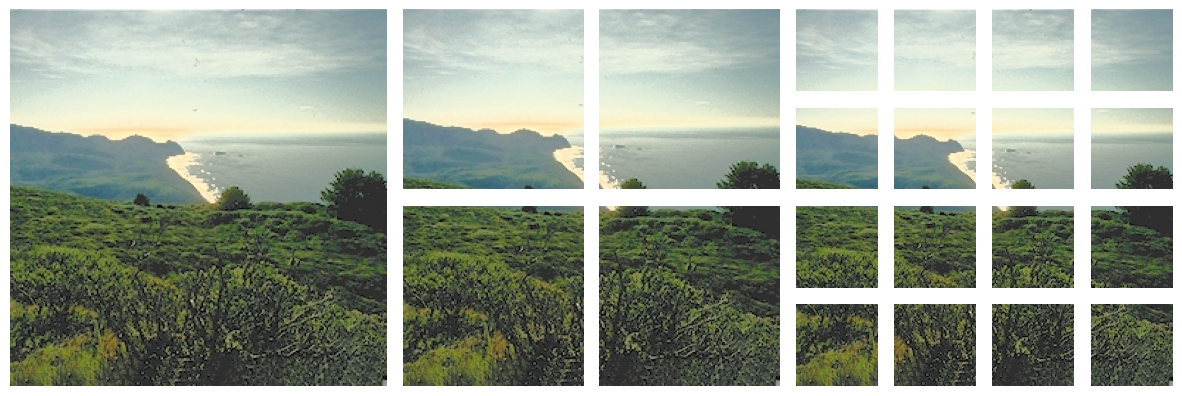

In [25]:
img_blocks = spatial_pyramid_square(img, SIFTdetector, level=2, plot=True)

## 3. SVM Classifier <a id="svm"></a>

In [26]:
def histogram_intersection(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Function that implements a histogram intersection. This can be used as a Kernel for svm.SVC

    Args:
        X (np.ndarray): First histogram
        Y (np.ndarray): Second histogram
    """
    inter_kernel = np.zeros((X.shape[0], Y.shape[0]))
    for x_col, y_col in zip(X, Y):
        inter_kernel += np.minimum(x_col, y_col) 
    return inter_kernel

In [27]:
def svm_classifier_fit(trial: int, X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray) -> np.ndarray:
        """
        Function that implements a SVM classifier. This function is used for hyperparameter optimization of parameters C and kernel.

        Args:
                trial (int): Trial number
                X_train (np.ndarray): Training data
                Y_train (np.ndarray): Training labels
                X_test (np.ndarray): Test data
        """
        c = trial.suggest_float("C", 1.0, 2.0)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid", histogram_intersection])
        degree = 3
        coef0 = 0.0
        gamma = "scale"
        if kernel == "poly":
                degree = trial.suggest_categorical("poly_degree", [3, 4, 5])
        if kernel == "sigmoid" or kernel == "poly":
                coef0 = trial.suggest_float("coef0", 0.0, 1.0)
        if kernel == "rbf" or kernel == "sigmoid" or kernel == "poly":
                gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        svc = SVC(C=c, kernel=kernel, degree=degree, coef0=coef0, gamma=gamma ,random_state=0)
        svc.fit(X_train, Y_train)
        Y_test = svc.predict(X_test)
        
        return Y_test

In [28]:
def objective(trial, descriptors: np.ndarray, labels: np.ndarray, codebook: MiniBatchKMeans, codebook_size: int) -> float:
    """
    Function that implements the objective function for hyperparameter optimization. This function is used for hyperparameter optimization of parameters C and kernel.
    
    Args:
        descriptors (np.ndarray): precomputed descriptors
        labels (np.ndarray): Labels
        codebook (MiniBatchKMeans): Codebook
        codebook_size (int): Codebook size
    """
    n_splits = 5
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(descriptors, labels)
    cumulative_accuracy = 0
    is_first_fold = True
    for train_index, test_index in tqdm(folds, "Fold", leave=False):
        X_train, Y_train = descriptors[train_index], train_labels[train_index]
        X_val, Y_val = descriptors[train_index], train_labels[train_index]
        
        vw_train, vw_val = compute_visual_words(X_train, X_val)
        X_train_DR, X_validate_DR = dimensionality_reduction(vw_train, Y_train, vw_val)
        predictions = svm_classifier_fit(trial, X_train_DR, Y_train, X_validate_DR)
        val_score = accuracy_score(y_true=Y_val, y_pred=predictions)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / n_splits

    return accuracy

In [29]:
# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial, descriptors=train_descriptors, labels=test_labels, codebook=codebook, codebook_size=codebook_size)

study = optuna.create_study(direction="maximize", study_name='svm-study', storage='sqlite:///final60.db', load_if_exists=True)
study.optimize(func, n_trials=50)

[I 2023-01-13 02:33:14,502] Using an existing study with name 'svm-study' instead of creating a new one.
[W 2023-01-13 02:33:14,523] Trial 3 failed because of the following error: NameError("name 'codebook' is not defined")
Traceback (most recent call last):
  File "/Users/eduard.hogea/miniforge3/envs/cv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/9m/k3vyv4317cz56g6f681k4jnm0000gn/T/ipykernel_52109/2691449830.py", line 2, in <lambda>
    func = lambda trial: objective(trial, descriptors=train_descriptors, labels=test_labels, codebook=codebook, codebook_size=codebook_size)
NameError: name 'codebook' is not defined


NameError: name 'codebook' is not defined

### Testing the BOVW with SVM

In [ ]:
params = {
    'detector': ['dense_sift'],
    'n_features': [2000],
    'codebook_size': [1024,2048],
    'step_size': [5,10,20,30,50],
    'dr_methods': ["pca", "lda"],
    'kp_sizes=kp_sizes': [1,2,3,4,8,10],
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1.0,2.0,3.0]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_svm.csv'

results = []

for n_features in params['n_features']:
    for step_div_size in params['step_size']:
        for kp_sizes in params['kp_sizes']:

            train_descriptors, filtered_train_labels = compute_descriptors(
                images=train_images,
                labels=train_labels,
                detector='dense_sift',
                n_features=n_features,
                step_div_size = step_div_size,
                kp_sizes = kp_sizes,
                desc='Computing descriptors for TRAIN images...'
            )


            for codebook_size in params['codebook_size']:

                cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                train_visual_words = compute_visual_words(
                    descriptors=train_descriptors,
                    codebook=cbook,
                    codebook_size=codebook_size,
                    desc="Computing visual words vocabulary with TRAIN descriptors..."
                )
            clf = svm.SVC()
            clf_grid = GridSearchCV(
                estimator=clf,
                param_grid={k: params[k] for k in ('kernel', 'C') if k in params},
                cv=8,
                scoring=evaluation_metrics,
                refit="accuracy",
                return_train_score=True)
            clf_grid.fit(train_visual_words, filtered_train_labels)

            idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

            # Params
            kernel = clf_grid.best_params_['kernel']
            C = clf_grid.best_params_['C']

            results_data = ['dense_sift', n_features, step_div_size, kp_sizes,codebook_size, kernel, C]

            # Scores
            for eval_metric in evaluation_metrics:
                train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                results_data.extend([train_score, val_score, std_train_score, std_val_score])

            results.append(results_data)
            print(f"Appended GridSearchCV results for {'dense_sift'} with {n_features} features, {step_div_size} step size, {kp_sizes} kp scale and {codebook_size} codebook size.")

columns = ['detector', 'n_features','step_size', 'kp_sizes', 'codebook_size', 'kernel', 'C'] \


for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

In [ ]:
df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")